# L-System for Space Engineers DEMO

Uses the `PCGSEPy` library included in this repository.

**NOTE**: Have the game *running*; leaving the game simply paused breaks the API (no calls are accepted). *Suggestion*: Use windowed mode, press `Start` after the scenario is loaded and return to this notebook.

Import Python packages:

In [1]:
import json

GECCO-compatible `matplotlib` options:

In [2]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Import `PCGSEPy` modules:

In [3]:
from pcgsepy.common.api_call import GameMode, get_base_values, toggle_gamemode
from pcgsepy.common.vecs import orientation_from_str, Vec 
from pcgsepy.config import COMMON_ATOMS, HL_ATOMS, N_ITERATIONS, REQ_TILES 
from pcgsepy.lsystem.rules import RuleMaker, StochasticRules
from pcgsepy.lsystem.actions import AtomAction, Rotations
from pcgsepy.lsystem.parser import HLParser, LLParser
from pcgsepy.lsystem.solver import LSolver
from pcgsepy.lsystem.constraints import ConstraintHandler, ConstraintLevel, ConstraintTime
from pcgsepy.lsystem.constraints_funcs import components_constraint, intersection_constraint, symmetry_constraint, wheels_plane_constraint
from pcgsepy.lsystem.lsystem import LSystem
from pcgsepy.structure import block_definitions, place_blocks, Structure

## Parsing rules

Rules are written in the text files (defined in the configuration file) and are then read and validated by the `RuleMaker`. A rule set is then created as a `StochasticRules` object.

The `LParser` expands a given axiom using its rule set.

**NOTE**: Rules can have multiple characters in the *RHS*, which allows for more complex axioms. Rules are stochastic (i.e.: $LHS \rightarrow p(RHS | LHS)$); to make a rule deterministic simply use a single $LHS \rightarrow RHS$ with $p=1.$.

## Alphabets

We define the alphabets used in the L-System.

Strings used as high-level structure:
- `cockpit`
- `engine`
- `corridor`
- `thruster`
- etc...

Strings used to define blocks:
- *See `block_definitions.json` for a full list*.

Strings used to define rotation commands:
- `rotXcwY`: Clockwise rotation from X to Y
- `rotXcwZ`: Clockwise rotation from X to Z
- `rotYcwX`: Clockwise rotation from Y to X 
- `rotYcwZ`: Clockwise rotation from Y to Z 
- `rotZcwX`: Clockwise rotation from Z to X 
- `rotZcwY`: Clockwise rotation from Z to Y 
- `rotXccwY`: Counter-clockwise rotation from X to Y 
- `rotXccwZ`: Counter-clockwise rotation from X to Z  
- `rotYccwX`: Counter-clockwise rotation from Y to X  
- `rotYccwZ`: Counter-clockwise rotation from Y to Z  
- `rotZccwX`: Counter-clockwise rotation from Z to X  
- `rotZccwY`: Counter-clockwise rotation from Z to Y   

Characters used as actions:
- `[` and `]`]: Push and pop current coordinate
- `+`: Move forward along `x`
- `-`: Move backward along `x`
- `!`: Move forward along `y`
- `?`: Move backward along `y`
- `>`: Move forward along `z`
- `<`: Move backward along `z`

We first have the alphabet comprised of common atoms.

In [4]:
with open(COMMON_ATOMS, "r") as f:
    common_alphabet = json.load(f)

for k in common_alphabet:
    action, args = common_alphabet[k]["action"], common_alphabet[k]["args"]
    action = AtomAction(action)
    if action == AtomAction.MOVE:
        args = orientation_from_str[args]
    elif action == AtomAction.ROTATE:
        args = Rotations(args)
    common_alphabet[k] = {"action": action, "args": args}

Then the alphabet with high-level atoms is loaded, providing also the dimension of each atom in a high-level structure.

We also define the offset of each atom. This is used when realigning the high-level structure for a rotation with the previous high-level structure.

In [5]:
with open(HL_ATOMS, "r") as f:
    hl_atoms = json.load(f)

tiles_dimensions = {}
tiles_block_offset = {}
for tile in hl_atoms.keys():
    dx, dy, dz = hl_atoms[tile]["dimensions"]
    tiles_dimensions[tile] = Vec.v3i(dx, dy, dz)
    tiles_block_offset[tile] = hl_atoms[tile]["offset"]

hl_alphabet = {}
for k in common_alphabet.keys():
    hl_alphabet[k] = common_alphabet[k]

for hk in hl_atoms.keys():
    hl_alphabet[hk] = {"action": AtomAction.PLACE, "args": []}

And then the alphabet of low-level atoms is loaded.

In [6]:
ll_alphabet = {}

for k in common_alphabet.keys():
    ll_alphabet[k] = common_alphabet[k]

for k in block_definitions.keys():
    if k != "":  # TODO: This is a probable bug, reported to the SE API devs
        ll_alphabet[k] = {"action": AtomAction.PLACE, "args": [k]}

## Solver class

The `Solver` can both solve for a given axiom and fill a `Structure` with an axiom.

In [7]:
hl_rules = RuleMaker(ruleset='hlrules').get_rules()
ll_rules = RuleMaker(ruleset='llrules').get_rules()

hl_parser = HLParser(rules=hl_rules)
ll_parser = LLParser(rules=ll_rules)

hl_solver = LSolver(parser=hl_parser,
                    atoms_alphabet=hl_alphabet,
                    extra_args={
                        'tiles_dimensions': tiles_dimensions,
                        'tiles_block_offset': tiles_block_offset,
                        'll_rules': ll_rules
                    })
ll_solver = LSolver(parser=ll_parser,
                    atoms_alphabet=dict(hl_alphabet, **ll_alphabet),
                    extra_args={})

## Constraints

Constraints are `ConstraintHandler` objects with a constraint function defined in the `pcgsepy.lsystem.constraints_funcs` module. Each of these constraints must always return a `bool` (`True` if the constraint is satisfied, `False` otherwise).

Additional parameters for the constraints can be defined by adding the parameter to the `extra_args` dictionary of the `ConstraintHandler` object after initialization.

In [8]:
rcc1 = ConstraintHandler(
    name="required_components",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.END,
    f=components_constraint,
    extra_args={
        'alphabet': hl_alphabet
    }
)
rcc1.extra_args["req_tiles"] = ['cockpit']

rcc2 = ConstraintHandler(
    name="required_components",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.END,
    f=components_constraint,
    extra_args={
        'alphabet': hl_alphabet
    }
)
rcc2.extra_args["req_tiles"] = ['corridorcargo', 'corridorgyros', 'corridorreactors']

rcc3 = ConstraintHandler(
    name="required_components",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.END,
    f=components_constraint,
    extra_args={
        'alphabet': hl_alphabet
    }
)
rcc3.extra_args["req_tiles"] = ['thrusters']

nic = ConstraintHandler(
    name="no_intersections",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.DURING,
    f=intersection_constraint,
    extra_args={
        'alphabet': dict(hl_alphabet, **ll_alphabet)
    },
    needs_ll=True
)
nic.extra_args["tiles_dimensions"] = tiles_dimensions

sc = ConstraintHandler(
    name="symmetry",
    level=ConstraintLevel.SOFT_CONSTRAINT,
    when=ConstraintTime.END,
    f=symmetry_constraint,
    extra_args={
        'alphabet': dict(hl_alphabet, **ll_alphabet)
    }
)

# wopc = ConstraintHandler(
#     name="wheels_on_plane",
#     level=ConstraintLevel.SOFT_CONSTRAINT,
#     when=ConstraintTime.END,
#     f=wheels_plane_constraint,
#     extra_args={
#         'alphabet': dict(hl_alphabet, **ll_alphabet)
#     }
# )

## L-System

The `LSystem` populates different structures with L-system solutions at different iterations.

In [9]:
import logging

logging.basicConfig()
logger = logging.getLogger('base-logger')
logger.setLevel(logging.INFO)

In [10]:
lsystem = LSystem(
    hl_solver=hl_solver, ll_solver=ll_solver, names=['HeadModule', 'BodyModule', 'TailModule']
)

We add the constraints to the `LSystem` at the correct abstraction level.

In [11]:
lsystem.add_hl_constraints(cs=[
    [nic, rcc1],
    [nic, rcc2],
    [nic, rcc3]
])

lsystem.add_ll_constraints(cs=[
    [sc],
    [sc],
    [sc]
])

We can run the L-System for a fixed number of iterations and obtain a candidate (high-level and low-level) axiom solution.

INFO:base-logger:[HeadModule] Started high level solving...
INFO:base-logger:Expansion n.1/1; current number of axioms: 1
INFO:base-logger:[HeadModule] Started low level solving...
INFO:base-logger:Expansion n.1/1; current number of axioms: 1
INFO:base-logger:[BodyModule] Started high level solving...
INFO:base-logger:Expansion n.1/5; current number of axioms: 1
INFO:base-logger:Expansion n.2/5; current number of axioms: 1
INFO:base-logger:Expansion n.3/5; current number of axioms: 2
INFO:base-logger:Expansion n.4/5; current number of axioms: 4
INFO:base-logger:Expansion n.5/5; current number of axioms: 8
INFO:base-logger:[BodyModule] Started low level solving...
INFO:base-logger:Expansion n.1/1; current number of axioms: 1
INFO:base-logger:Expansion n.1/1; current number of axioms: 1
INFO:base-logger:[TailModule] Started high level solving...
INFO:base-logger:Expansion n.1/1; current number of axioms: 1
INFO:base-logger:[TailModule] Started low level solving...
INFO:base-logger:Expans

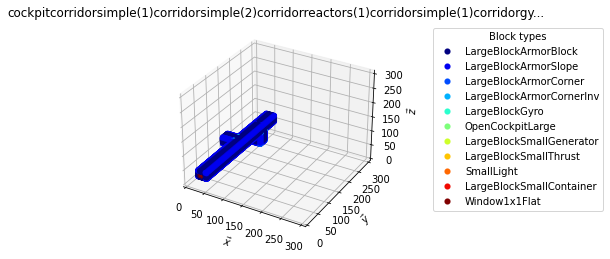

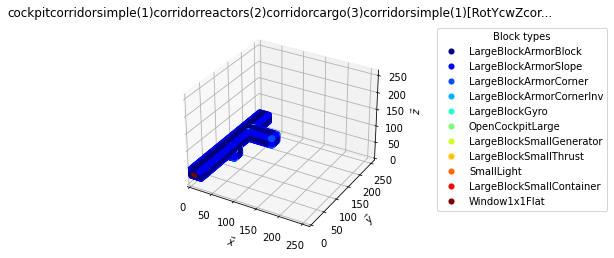

High Level Axioms:
	: cockpitcorridorsimple(1)corridorsimple(2)corridorreactors(1)corridorsimple(1)corridorgyros(4)[RotYcwXcorridorsimple(1)thrusters(1)]corridorsimple(1)corridorsimple(2)corridorsimple(1)[RotYcwZcorridorsimple(2)]corridorcargo(2)thrusters
	: cockpitcorridorsimple(1)corridorreactors(2)corridorcargo(3)corridorsimple(1)[RotYcwZcorridorsimple(1)]corridorcargo(1)corridorsimple(1)[RotYccwXcorridorsimple(3)]corridorgyros(1)corridorcargo(2)thrusters
Low Level Axioms:
	: LargeBlockArmorSlope(B,L)+(5)LargeBlockArmorBlock(F,U)+(5)LargeBlockArmorBlock(F,U)+(5)LargeBlockArmorBlock(F,U)+(5)LargeBlockArmorSlope(B,R)!(5)-(20)LargeBlockArmorSlope(B,L)+(5)LargeBlockArmorBlock(F,U)+(5)LargeBlockArmorBlock(F,U)+(5)LargeBlockArmorBlock(F,U)+(5)LargeBlockArmorSlope(B,R)!(5)-(20)LargeBlockArmorSlope(B,L)+(5)LargeBlockArmorBlock(F,U)+(5)LargeBlockArmorBlock(F,U)+(5)LargeBlockArmorBlock(F,U)+(5)LargeBlockArmorSlope(B,R)<(5)?(10)-(20)LargeBlockArmorBlock(F,U)+(5)Window1x1Flat(B,R)+(5)Window1x1F

In [15]:
structures, hl_axioms, ll_axioms = lsystem.apply_rules(
    starting_axioms=[
        'head',
        'body',
        'tail'
    ],
    iterations=[
        1,
        N_ITERATIONS,
        1
    ],
    create_structures=True,
    make_graph=True,
)

div = '\n\t: '
print(f'High Level Axioms:\n\t: {div.join(hl_axioms)}\nLow Level Axioms:\n\t: {div.join(ll_axioms)}')

# Game interaction

Place structure in-game by updating its position and rotation according to the player.

In [16]:
do_place_blocks = True

In [17]:
if do_place_blocks:
    base_position, orientation_forward, orientation_up = get_base_values()
    structures[0].update(
        origin=base_position,
        orientation_forward=orientation_forward,
        orientation_up=orientation_up,
    )
    toggle_gamemode(GameMode.PLACING)
    place_blocks(structures[0].get_all_blocks(), False)
    toggle_gamemode(GameMode.EVALUATING)